In [1]:
import pickle
import pandas as pd
import os
import math
import numpy as np
from scipy.spatial import distance
from joblib import Parallel, delayed

In [2]:
ht_vector_src = "./data/ht_data/results/final/aggregated_ht_data.pkl"
ul_vector_src = "./data/clean_data_unlabeled/results/aggregated_data_v2/"
pair_wise_distance_dest = "./data/clusters/node_distance/utilities/"
n = 36  # number of clusters in the population

In [3]:
ht_vectors = pickle.load(open(ht_vector_src,"rb"))

In [4]:
ul_vectors = pd.DataFrame()
count = 0
for file_name in os.listdir(ul_vector_src):
    file_path = os.path.join(ul_vector_src,file_name)
    pickle_data = pd.read_pickle(file_path)
    ul_vectors = ul_vectors.append(pickle_data)

In [5]:
ht_group_by_category = ht_vectors.groupby(["category"])

In [6]:
ht_clusters_mean = ht_vectors.groupby(["category"]).apply(lambda x: np.mean(x["vec"]))

In [7]:
ul_group_by_category = ul_vectors.groupby(["category"])

In [8]:
ul_clusters_mean = ul_vectors.groupby(["category"]).apply(lambda x: np.mean(x["vec"]))

In [9]:
ht_clusters = dict(list(ht_group_by_category))
ul_clusters = dict(list(ul_group_by_category))

In [1]:
cluster_label = "gifts"
node_flag = {}

cluster_by_category = pd.DataFrame()
print(cluster_by_category)
ht_cluster_data = ht_clusters[cluster_label]
ht_cluster_data['tag_category'] = "ht"
ul_cluster_data = ul_clusters[cluster_label]
ul_cluster_data['tag_category'] = "ul"
print(ht_cluster_data.count())
print(ul_cluster_data.count())
cluster_by_category = cluster_by_category.append(ht_cluster_data)
cluster_by_category = cluster_by_category.append(ul_cluster_data)
cluster_by_category = cluster_by_category.reset_index()
number_of_element_in_ht = ht_cluster_data.count()["category"]
number_of_element_in_ul = ul_cluster_data.count()["category"]
total_number_of_element = number_of_element_in_ht + number_of_element_in_ul

for node_index in range(0,number_of_element_in_ht):
    node_flag[node_index] = 1
for node_index in range(number_of_element_in_ht,total_number_of_element):
    node_flag[node_index] = 0

    
def calculate_pair_wise_distance(min_node_id,max_node_id):
    group_of_node_distance = []
    for node_id in range(min_node_id,max_node_id):
        try:
            distance_list = []
            desc2vec = cluster_by_category.loc[node_id]["vec"]
            for node_index in range(0,total_number_of_element):
                distance_list.append(distance.euclidean(desc2vec,cluster_by_category.loc[node_index]["vec"]))
            group_of_node_distance.append({'node_id':node_id,'distance_list':distance_list})
        except:
            print("exception occurred for node id",node_id)
    distance_list = pd.DataFrame(group_of_node_distance)
    pickle.dump(distance_list,open(os.path.join(pair_wise_distance_dest,"dist_node_"+str(min_node_id)+"_"+str(max_node_id)+".pkl"),"wb"))
    print("dumping for node ",min_node_id," - ",max_node_id)
    

index_list = []
number_of_data = number_of_element_in_ul
number_of_elements = math.ceil(number_of_data/n)
for i in range(0,n):
    min_index = number_of_element_in_ht + number_of_elements*i
    max_index = min_index+number_of_elements
    index_list.append({'min_index':min_index,'max_index':max_index})
Parallel(n_jobs=n)(delayed(calculate_pair_wise_distance)(index["min_index"],index["max_index"]) for index in index_list)

In [ ]:
#edge_weight = np.zeros([total_number_of_element,total_number_of_element])
# calculate distance for ul elements only
for row_index in range(0,total_number_of_element):
    for col_index in range(row_index+1,total_number_of_element):
        edge_weight[row_index][col_index] = distance.euclidean(cluster_by_category.loc[row_index]["vec"],cluster_by_category.loc[col_index]["vec"])
    for col_index in range(0,row_index+1):
        edge_weight[row_index][col_index] = edge_weight[col_index][row_index] 
#     if row_index % 10 == 0:
    print(row_index)
        
mean_of_cluster = 2
std_of_cluster = 1
theta = 1.96

In [10]:
#load weighted graph
edge_weight = pd.DataFrame()
for file_name in os.listdir(pair_wise_distance_dest):
    pickle_data = pd.read_pickle(os.path.join(pair_wise_distance_dest,file_name))
    edge_weight = edge_weight.append(pickle_data)
edge_weight = edge_weight.reset_index()

In [11]:
count = 0
node_wise_mean = np.zeros([int(edge_weight.count()["node_id"])])
node_wise_std = np.zeros([int(edge_weight.count()["node_id"])])
for distance_list in edge_weight["distance_list"]:
    node_wise_mean[count] = np.mean(distance_list)
    node_wise_std[count] = np.std(distance_list)
    count += 1
mean_of_cluster = np.mean(node_wise_mean)


In [12]:
cluster_label = "utilities"
node_flag = {}

cluster_by_category = pd.DataFrame()
# print(cluster_by_category)
ht_cluster_data = ht_clusters[cluster_label]
ht_cluster_data['tag_category'] = "ht"
ul_cluster_data = ul_clusters[cluster_label]
ul_cluster_data['tag_category'] = "ul"
# print(ht_cluster_data.count())
# print(ul_cluster_data.count())
cluster_by_category = cluster_by_category.append(ht_cluster_data)
cluster_by_category = cluster_by_category.append(ul_cluster_data)
cluster_by_category = cluster_by_category.reset_index()
number_of_element_in_ht = ht_cluster_data.count()["category"]
number_of_element_in_ul = ul_cluster_data.count()["category"]
total_number_of_element = number_of_element_in_ht + number_of_element_in_ul

for node_index in range(0,number_of_element_in_ht):
    node_flag[node_index] = 1
for node_index in range(number_of_element_in_ht,total_number_of_element):
    node_flag[node_index] = 0
    
    
theta = -2.5
for node_index in range(0,int(edge_weight.count()["node_id"])):
    node_id = edge_weight.loc[node_index]["node_id"]
    distance_list = edge_weight.loc[node_index]["distance_list"]
    for index in range(0,len(distance_list)):
        if node_flag[index] == 1 and distance_list[index] < (node_wise_mean[node_index] + theta * node_wise_std[node_index]):
            node_flag[node_id] = -1
            break
    if node_flag[node_id] == 0:
        node_flag[node_id] = 1

In [2]:
count_discard = 0
count_anchor = 0
count_unalloc = 0
for key in node_flag.keys():
    if node_flag[key] == 0:
        count_unalloc += 1
    elif node_flag[key] == 1:
        count_anchor += 1
    elif node_flag[key] == -1:
        count_discard += 1
print(count_anchor," : ",count_discard," : ",count_unalloc)
print(count_discard*100/number_of_element_in_ul)

In [27]:
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from scipy.stats import norm

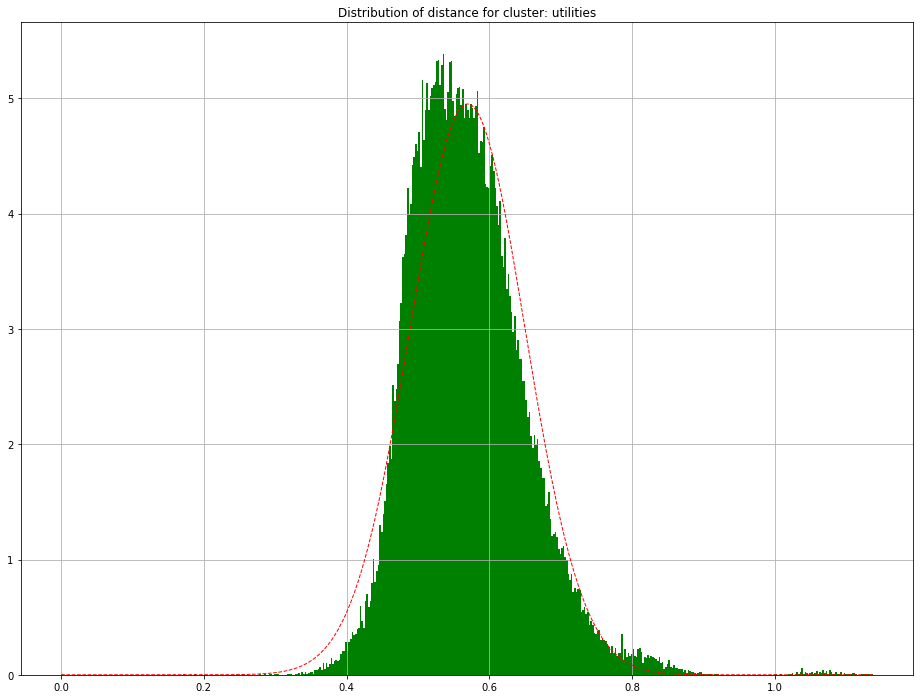

In [36]:
width = 16
height = 12
plt.figure(figsize=(width, height))
distance_corpus = []
for node_index in range(0,2):
    distance_corpus += (edge_weight.loc[node_index]["distance_list"])
# print(len(distance_corpus))
x = distance_corpus

# the histogram of the data
n, bins, patches = plt.hist(x, 500, normed=1, facecolor='green', alpha=1)
# best fit of data
(mu, sigma) = norm.fit(x)
# add a 'best fit' line
y = mlab.normpdf( bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=1)
plt.title("Distribution of distance for cluster: utilities")
# xlocs, xlabs = plt.xticks()
# plt.xticks(xlocs, xlabs)
# plt.xticks(xValues)
plt.grid(True)
plt.show()

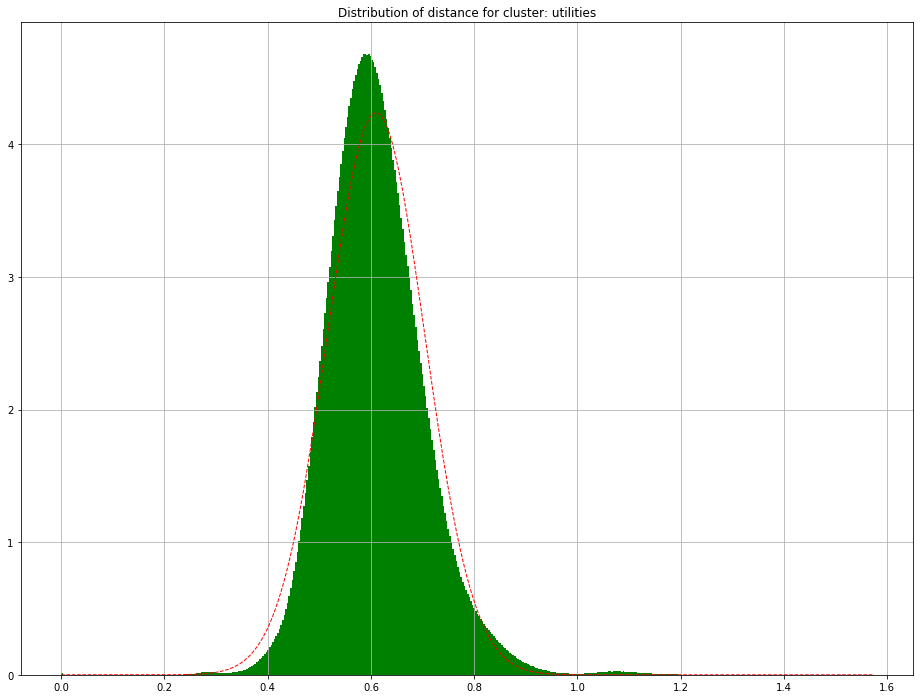

In [42]:
width = 16
height = 12
plt.figure(figsize=(width, height))
distance_corpus = []
for node_index in range(0,3500):
    distance_corpus += (edge_weight.loc[node_index]["distance_list"])
# print(len(distance_corpus))
x = distance_corpus

# the histogram of the data
n, bins, patches = plt.hist(x, 500, normed=1, facecolor='green', alpha=1)
# best fit of data
(mu, sigma) = norm.fit(x)
# add a 'best fit' line
y = mlab.normpdf( bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=1)
plt.title("Distribution of distance for cluster: utilities")
# xlocs, xlabs = plt.xticks()
# plt.xticks(xlocs, xlabs)
# plt.xticks(xValues)
plt.grid(True)
plt.show()

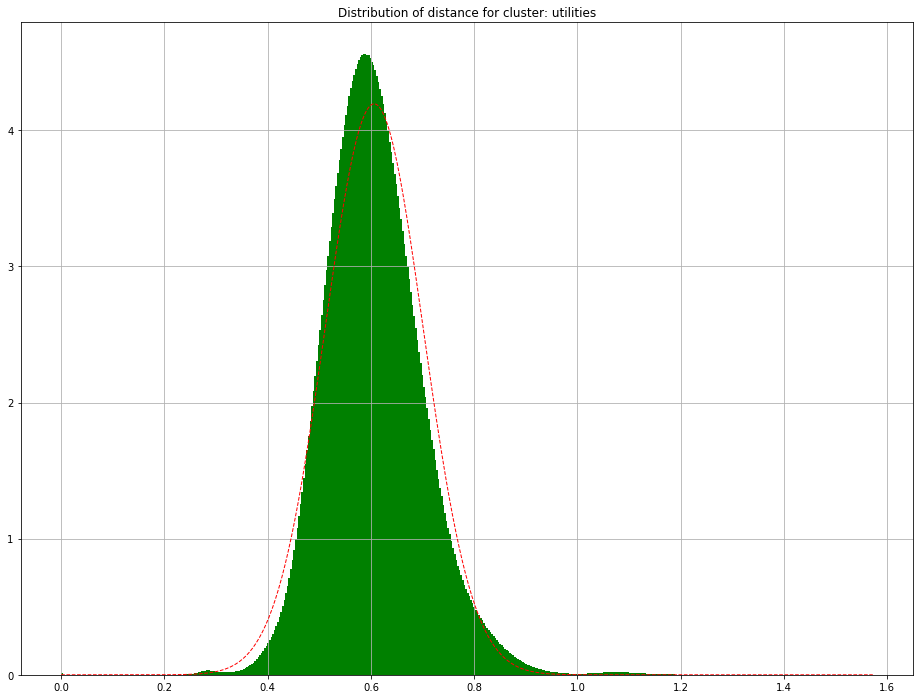

In [43]:
width = 16
height = 12
plt.figure(figsize=(width, height))
distance_corpus = []
for node_index in range(0,int(edge_weight.count()["node_id"])):
    distance_corpus += (edge_weight.loc[node_index]["distance_list"])
# print(len(distance_corpus))
x = distance_corpus

# the histogram of the data
n, bins, patches = plt.hist(x, 500, normed=1, facecolor='green', alpha=1)
# best fit of data
(mu, sigma) = norm.fit(x)
# add a 'best fit' line
y = mlab.normpdf( bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=1)
plt.title("Distribution of distance for cluster: utilities")
# xlocs, xlabs = plt.xticks()
# plt.xticks(xlocs, xlabs)
# plt.xticks(xValues)
plt.grid(True)
plt.show()